In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [4]:
#Set execution flags
RUNNING_ON_FLOYDHUB = False
epochs=100

In [5]:
# Local data directories
if not RUNNING_ON_FLOYDHUB:
    print('Linking to local data directories.')
    train_dir = 'data/dogs-vs-cats-small/train'
    test_dir = 'data/dogs-vs-cats-small/test'
    validation_dir = 'data/dogs-vs-cats-small/validation'
    output_dir = 'models/'
else:
    print('Linking to floydhub data directories mounted at /data .')
    train_dir = '/data/dogs-vs-cats-small/train'
    test_dir = '/data/dogs-vs-cats-small/test'
    validation_dir = '/data/dogs-vs-cats-small/validation'
    output_dir = '/output'

Linking to local data directories.


### Image Augmentation

In [6]:
datagen = image.ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  fill_mode='nearest',
                                  horizontal_flip=True,
                                  data_format='channels_last')

In [7]:
# Filenames from training directory
file_idx = 100
train_cat_files = [ os.path.join(train_dir, 'cats', fname) for fname in os.listdir(os.path.join( train_dir, 'cats')) ]
img = image.load_img(train_cat_files[file_idx], target_size=(150, 150))
img_array = image.img_to_array(img)
print('Array shape: {0}.'.format(img_array.shape))

print('ImageDataGenerator.flow() needs shape to be in format (samples, height, width, channel).')
img_array = img_array.reshape((1,) + img_array.shape)
print('New array shape: {0}.'.format(img_array.shape))

Array shape: (150, 150, 3).
ImageDataGenerator.flow() needs shape to be in format (samples, height, width, channel).
New array shape: (1, 150, 150, 3).


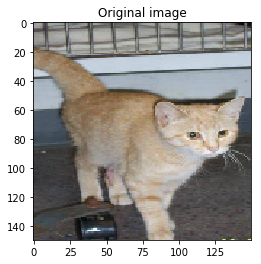

In [8]:
plt.figure()
plt.imshow(image.array_to_img(img_array[0]))
plt.title('Original image')
plt.show()

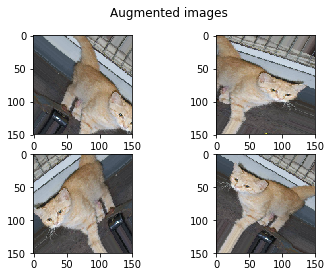

In [9]:
count = 1
fig = plt.figure()
for augmented_batch in datagen.flow(img_array, batch_size=1):
    ax = fig.add_subplot(2, 2, count)
    ax.imshow(image.array_to_img(augmented_batch[0]))
    count += 1
    if count % 5 == 0:
        break
plt.suptitle('Augmented images')
plt.show()

In [10]:
test_datagen = image.ImageDataGenerator(rescale=1./255) #Should not modify test and validation images
train_datagen = image.ImageDataGenerator(rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         rescale=1./255)

In [11]:
train_batches = train_datagen.flow_from_directory(train_dir,
                                                target_size=(150, 150),
                                                class_mode='binary',
                                                batch_size=20)
validation_batches = test_datagen.flow_from_directory(validation_dir,
                                                   target_size=(150, 150),
                                                   class_mode='binary',
                                                   batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Model

In [12]:
from keras import models, layers, optimizers

In [13]:
#Create convolutional neural network
convnet = models.Sequential()

convnet.add( layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)) )
convnet.add( layers.MaxPooling2D() )

convnet.add( layers.Conv2D(64, (3, 3), activation='relu') )
convnet.add( layers.MaxPooling2D() )

convnet.add( layers.Conv2D(128, (3, 3), activation='relu') )
convnet.add( layers.MaxPooling2D() )

convnet.add( layers.Conv2D(128, (3, 3), activation='relu') )
convnet.add( layers.MaxPooling2D() )

convnet.add( layers.Flatten() )
convnet.add( layers.Dropout(0.5) )
convnet.add( layers.Dense( 512, activation='relu' ) )
convnet.add( layers.Dense( 1, activation='sigmoid' ) )

convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [14]:
convnet.compile( optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'] )

### Train

In [15]:
history = convnet.fit_generator(train_batches, steps_per_epoch=100, epochs=epochs, validation_data=validation_batches, validation_steps=50)
convnet.save(os.path.join(output_dir, 'cats_vs_dogs_small_dropout_2.h5'))

Epoch 1/100
100/100 [==============================] - 159s 2s/step - loss: 0.6929 - acc: 0.5275 - val_loss: 0.6995 - val_acc: 0.4990
Epoch 2/100
100/100 [==============================] - 158s 2s/step - loss: 0.6864 - acc: 0.5420 - val_loss: 0.6739 - val_acc: 0.5740
Epoch 3/100
100/100 [==============================] - 158s 2s/step - loss: 0.6765 - acc: 0.5680 - val_loss: 0.6573 - val_acc: 0.6080
Epoch 4/100
100/100 [==============================] - 195s 2s/step - loss: 0.6538 - acc: 0.6230 - val_loss: 0.6358 - val_acc: 0.6470
Epoch 5/100
100/100 [==============================] - 175s 2s/step - loss: 0.6474 - acc: 0.6285 - val_loss: 0.6185 - val_acc: 0.6580
Epoch 6/100
100/100 [==============================] - 159s 2s/step - loss: 0.6314 - acc: 0.6380 - val_loss: 0.6055 - val_acc: 0.6640
Epoch 7/100
100/100 [==============================] - 159s 2s/step - loss: 0.6177 - acc: 0.6520 - val_loss: 0.6104 - val_acc: 0.6270
Epoch 8/100
100/100 [==============================] - 179s 2s

### Plots

In [16]:
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

train_loss = history.history['loss']
train_acc = history.history['acc']

epoch = history.epoch

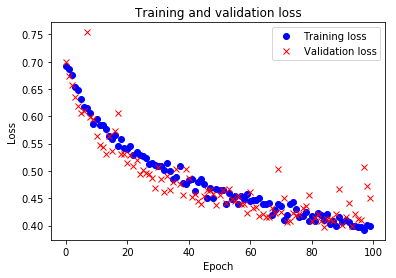

In [17]:
# Loss plots
plt.figure()

plt.plot(epoch, train_loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'rx', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

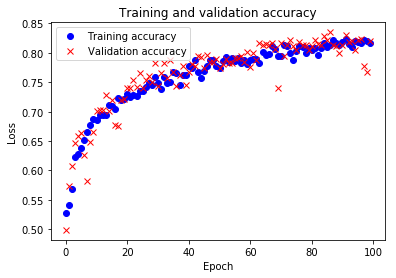

In [18]:
# Accuracy plots
plt.figure()

plt.plot( epoch, train_acc, 'bo', label='Training accuracy' )
plt.plot( epoch, val_acc, 'rx', label='Validation accuracy' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()